# Example 3

## Double-difference loss function for 2D case

**Content**

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## Import *hcpinnseikonal* package functions

In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from argparse import ArgumentParser   
from scipy import interpolate

from hcpinnseikonal.utils import *
from hcpinnseikonal.model import *
from hcpinnseikonal.traindds import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_fulldds'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'nu_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriz

## Define arguments

In [2]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=500
args.seed=1234 
args.learning_rate=1e-3 
args.rescale_plot='y' 
args.initial_velocity=3 
args.zid_source=5 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='marmousi' 
args.v_multiplier=3 
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=8.6 
args.max_depth=1 
args.vertical_spacing=0.01 
args.lateral_spacing=0.03 
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.1 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=20 
args.sou_spacing=40

dict_args = vars(args)
print(dict_args)

{'lateral_spacing': 0.03, 'vertical_spacing': 0.01, 'max_offset': 8.6, 'max_depth': 1, 'rec_spacing': 20, 'sou_spacing': 40, 'num_epochs': 500, 'num_neurons': 24, 'num_layers': 12, 'learning_rate': 0.001, 'model_type': 'marmousi', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 50, 'seed': 1234, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'y', 'depth_shift': 'n', 'tau_multiplier': 1, 'initial_velocity': 3, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'y', 'xid_well': 5, 'last_vmultiplier': 5, 'nu_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.1, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': 'tanh', 'empty_middle': 'n', 'factoriz

## Medium setup and data interpolation

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 8000
4.486768969918806 15 15 8 28


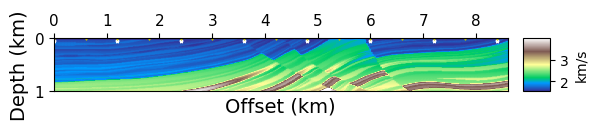

In [3]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = -0.1 if args.field_synthetic=='y' else 0; zmax = args.max_depth; deltaz = args.vertical_spacing;
xmin = 0.; xmax = args.max_offset; deltax = args.lateral_spacing;

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

# Creating grid, extending the velocity model, and prepare list of grid points for training
z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

# Number of training points
num_tr_pts = 4000 #int(args.num_points * nz * nx)

if args.field_synthetic=='y':
    import pandas as pd
    import pygmt
    import numpy as np

    import pandas as pd

    # Earthquake events location
    location = pd.read_csv('/home/taufikmh/KAUST/fall_2022/GFATT_PINNs/data/fang_etal_2020/sjfzcatlog.csv')

    # Recorded traveltime data
    traveltime = pd.read_table('/home/taufikmh/KAUST/fall_2022/GFATT_PINNs/data/fang_etal_2020/sjfz_traveltime.dat', delim_whitespace='y')

    # Rounding to make the coordinates rounding the same
    location, traveltime = location.round(3), traveltime.round(3)

    # Merge
    data = pd.merge(traveltime, location,  how='left', left_on=['evlat','evlon','evdep'], right_on = ['evlat','evlon','evdep'])

    # Create earthquake group
    data['event_id'] = data.groupby(['evlat', 'evlon', 'evdep']).cumcount() + 1
    data['station_id'] = data.groupby(['stlat', 'stlon', 'stele']).cumcount() + 1

    # Station only
    sta_only = data.drop_duplicates(subset=['stlat', 'stlon'], keep='last')

    # Event only
    eve_only = data.drop_duplicates(subset=['evlat', 'evlon'], keep='last')

    region = [-118, -115, 32.5, 34.50]
    x0,x1,y0,y1 = -117.45, -115.55, 34.15, 32.76

    # eve_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(eve_only.event_id.values), y0*np.ones_like(eve_only.event_id.values)])
    p2=np.array([(360+x1)*np.ones_like(eve_only.event_id.values), y1*np.ones_like(eve_only.event_id.values)])
    p3=np.array([eve_only.evlon, eve_only.evlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    eve_only.loc[:, 'closest_event'] = np.copy(d[0].values)

    # sta_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(sta_only.station_id.values), y0*np.ones_like(sta_only.station_id.values)])
    p2=np.array([(360+x1)*np.ones_like(sta_only.station_id.values), y1*np.ones_like(sta_only.station_id.values)])
    p3=np.array([sta_only.stlon, sta_only.stlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    sta_only.loc[:, 'closest_station'] = np.copy(d[0].values)

    closest_sta = sta_only[np.abs(sta_only['closest_station'])<0.003]
    closest_eve = eve_only[np.abs(eve_only['closest_event'])<0.00003]

    grid = pygmt.datasets.load_earth_relief(resolution="03m", region=region)

    points = pd.DataFrame(
        data=np.linspace(start=(x0, y0), stop=(x1, y1), num=len(x)),
        columns=["x", "y"],
    )

    track = pygmt.grdtrack(points=points, grid=grid, newcolname="elevation")
    xtop = track.x.values + 360
    ztop = track.elevation.values*1e-3

    xsta = closest_sta.stlon.values
    zsta = closest_sta.stele.values

    xeve = closest_eve.evlon.values
    zeve = closest_eve.evdep.values

    xtop,xsta,xeve = xtop-xtop.min(),xsta-xsta.min(),xeve-xeve.min()
    xtop,xsta,xeve = xtop/xtop.max()*xmax,xsta/xsta.max()*xmax,xeve/xeve.max()*xmax

    ztop,zsta,zeve = ztop-ztop.min(),zsta-zsta.min(),zeve-zeve.min()
    ztop,zsta,zeve = args.station_factor*ztop/ztop.max()+zmin,args.station_factor*zsta/zsta.max()+zmin,zmax-args.event_factor*zeve/zeve.max()

    xsta,xeve,zsta,zeve = xsta[(xsta>xtop.min()) & (xsta<xtop.max())],xeve[(xeve>xtop.min()) & (xeve<xtop.max())],zsta[(xsta>xtop.min()) & (xsta<xtop.max())],zeve[(xeve>xtop.min()) & (xeve<xtop.max())]

    if args.exclude_topo=='y':
        ztop, zsta = zmin*np.ones_like(ztop), zmin*np.ones_like(zsta)

    ztop, zsta = zmin-ztop, zmin-zsta

    id_sou_z = np.array([]).astype(int)

    for szi in zeve.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_sou_z = np.append(id_sou_z,sid)

    id_rec_z = np.array([]).astype(int)

    for rzi in zsta.round(2):
        sid = np.where(np.abs(z.round(3)-rzi)<1e-6)
        id_rec_z = np.append(id_rec_z,sid)

    id_sou_x = np.array([]).astype(int)

    for sxi in xeve.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1.5e-2)
        id_sou_x = np.append(id_sou_x,sid)

    id_rec_x = np.array([]).astype(int)

    for rxi in xsta.round(2):
        sid = np.where(np.abs(x.round(3)-rxi)<1.5e-2)
        id_rec_x = np.append(id_rec_x,sid)

    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    if args.regular_station=='y':
        id_rec_x = id_top_x[::args.rec_spacing]
        id_rec_z = id_top_z[::args.rec_spacing]

    if args.append_shot=='y':
        for i in range(8):
            id_sou_x = np.append(id_sou_x, len(x)-1-2*i)
            id_sou_z = np.append(id_sou_z, len(z)-1-int(0.5*i))
            
    plt.plot(args.plotting_factor*(xtop-xtop.min()), args.plotting_factor*ztop)
    plt.scatter(args.plotting_factor*(xeve-xtop.min()), args.plotting_factor*zeve)
    plt.scatter(x[id_rec_x], z[id_rec_z], c='y', marker='v')
    plt.title('Cross-section')
    plt.xlabel('X (km)')
    plt.ylabel('Z (km)')
    plt.gca().invert_yaxis()
    plt.axis('tight')
    plt.savefig(os.path.join(wandb_dir, 'cross_section.png'), format='png', bbox_inches="tight")
else:
    zeve, xeve = z[args.zid_source]*np.ones_like(x[::deltas]), x[::deltas]
    zsta, xsta = z[args.zid_receiver]*np.ones_like(x[::deltar]), x[::deltar]
    ztop, xtop = zmin*np.ones_like(x), np.copy(x)

    id_sou_z = np.array([]).astype(int)

    for szi in zeve.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_sou_z = np.append(id_sou_z,sid)

    id_sou_x = np.array([]).astype(int)

    for sxi in xeve.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1e-6)
        id_sou_x = np.append(id_sou_x,sid)

    id_rec_z = np.array([]).astype(int)

    for szi in zsta.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_rec_z = np.append(id_rec_z,sid)

    id_rec_x = np.array([]).astype(int)

    for sxi in xsta.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1e-6)
        id_rec_x = np.append(id_rec_x,sid)

# Keeping the number of shots fixed while centering the shots location
if args.middle_shot=='y':
    id_sou_left = x.shape[0]//2-len(id_sou_x)//2
    id_sou_x = np.array(range(id_sou_left, id_sou_left+len(id_sou_x)))

if args.explode_reflector=='y':
    id_sou_x = np.arange(0, len(x), args.sou_spacing)
    id_sou_z = np.ones_like(id_sou_x)*(len(z)-1)

if args.empty_middle=='y':
    id_sou, id_rec = (np.array(id_sou_x)<=(len(x)//2-50))|(np.array(id_sou_x)>=(len(x)//2+50)), (np.array(id_rec_x)<=(len(x)//2-50))|(np.array(id_rec_x)>=(len(x)//2+50))
    if args.field_synthetic=='n':
        id_sou_x = np.array(id_sou_x)[id_sou]
        id_sou_z = np.array(id_sou_z)[id_sou]
    id_rec_x = np.array(id_rec_x)[id_rec]
    id_rec_z = np.array(id_rec_z)[id_rec]


# Computational model parameters

sz = z[id_sou_z]
sx = x[id_sou_x]
ns = len(sx)

sources = 0;
sx1 = []; sx2 = [];
id_sou_x1 = []; id_sou_x2 = [];

for idx, i in enumerate(sx):
    for jdx, j in enumerate(sx):
        if i==j or i>j:
            continue
        else:
            sx1.append(i)
            sx2.append(j)
            id_sou_x1.append(id_sou_x[idx])
            id_sou_x2.append(id_sou_x[jdx])
            sources+=1

id_sou_z1 = [args.zid_source]*len(id_sou_x1); id_sou_z2 = [args.zid_source]*len(id_sou_x2);
            
Z1,X1,SX1 = np.meshgrid(z,x,sx1,indexing='ij')
_,_,SX2 = np.meshgrid(z,x,sx2,indexing='ij')

SZ = np.ones(SX1.shape)*z[args.zid_source]

X_star1 = [Z1.reshape(-1,1), X1.reshape(-1,1), SX1.reshape(-1,1)] 
X_star2 = [Z1.reshape(-1,1), X1.reshape(-1,1), SX2.reshape(-1,1)] 

vel = np.fromfile('../data/marmousi.bin', np.float32).reshape(221, 601)
x1 = np.linspace(0, 5, 601)
z1 = np.linspace(0, 1, 221) 
x2 = np.linspace(0.25, 5, len(x))
z2 = np.linspace(0.09, 0.55, len(z)) 
f = interpolate.interp2d(x1, z1, vel, kind='cubic')
vel = f(x2, z2)

# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel[...,np.newaxis], len(sx1), axis=2)

print(np.nanmax(velmodel), len(id_rec_z), len(id_rec_x), len(id_sou_z), len(id_sou_x1))
plot_section(velmodel[:,:,0], 'v_true.png', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

if args.depth_shift=='y':
    zmin, zmax, z, sz, Z, SZ = zmin+5, zmax+5, z+5, sz+5, Z+5, SZ+5

# Numerical traveltime
T_data1 = numerical_traveltime(vel, len(x), len(z), len(id_sou_x1), xmin, zmin, deltax, deltaz, id_sou_x1, id_sou_z1)
T_data2 = numerical_traveltime(vel, len(x), len(z), len(id_sou_x2), xmin, zmin, deltax, deltaz, id_sou_x2, id_sou_z2)

# Plots
if args.model_type=='checkerboard':
    plot_section((6 + 6.5217391304347826*Z[:,:,0])/args.scale_factor, "v_back.png", 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])
    plot_section(velpert[:,:,0]/args.scale_factor, "v_pert.png", 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

### Source 1

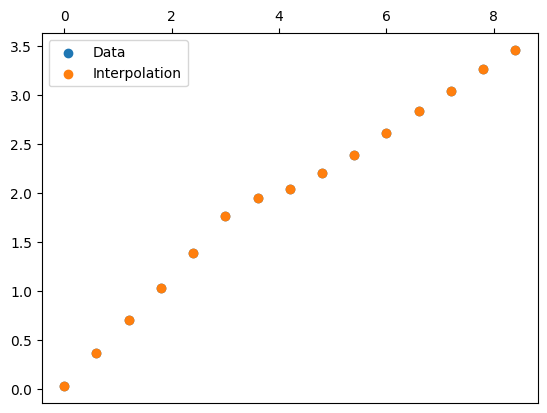

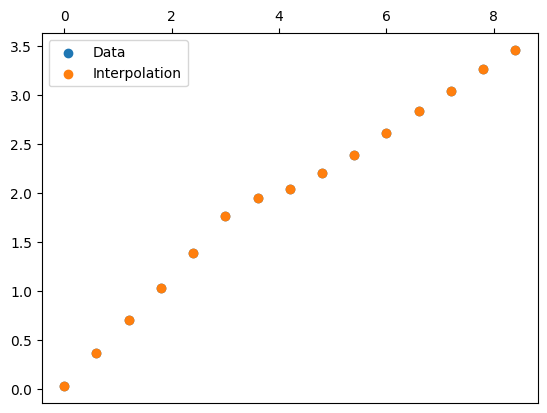

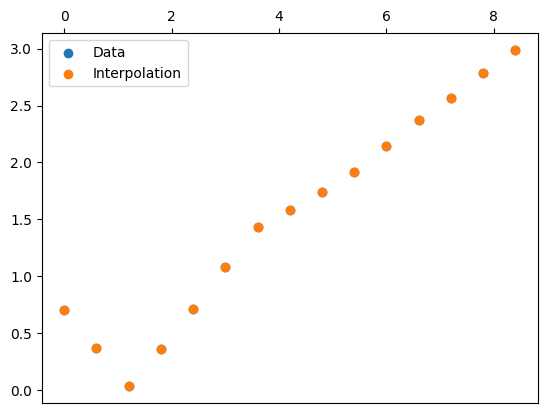

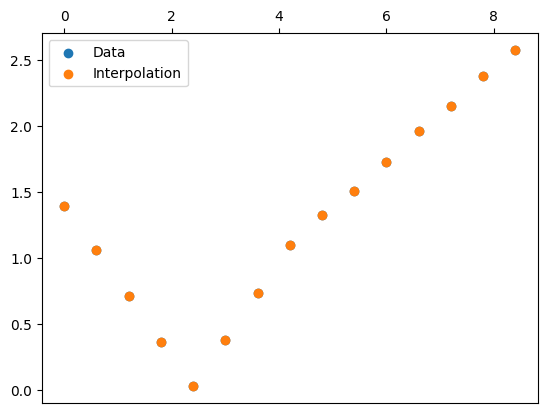

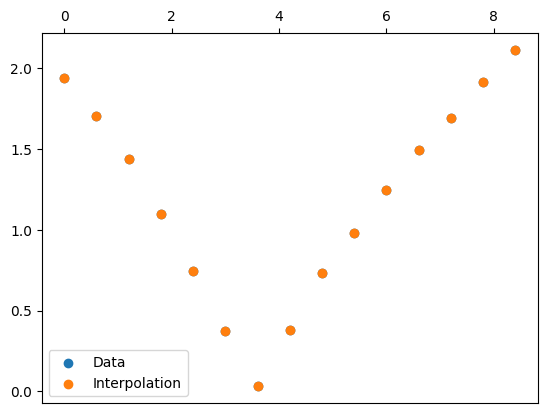

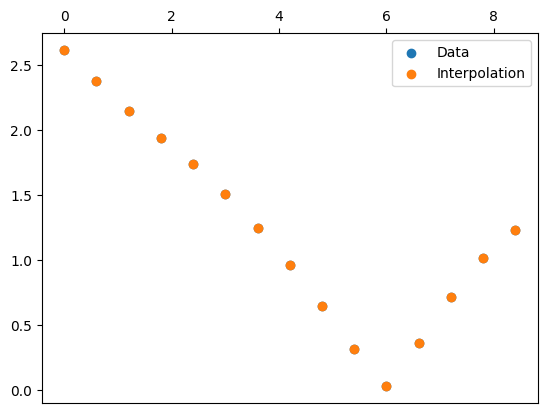

In [4]:
# Interpolation
Td_nn1 = np.zeros_like(T_data1)
taudx_nn1 = np.zeros_like(T_data1)

Ti_data1 = np.zeros((len(x[id_rec_x])*len(id_sou_x1)))
xri1 = np.tile(x[id_rec_x], len(id_sou_x1))
zri1 = np.tile(z[id_rec_z], len(id_sou_z1))
xsi1 = np.repeat(x[id_sou_x1], len(id_rec_x))
zsi1 = np.repeat(z[id_sou_z1], len(id_rec_z))

for i in range(len(id_sou_x1)):
    Ti_data1[i*len(x[id_rec_x]):(i+1)*len(x[id_rec_x])] = T_data1[id_rec_z,id_rec_x,i]

rand_idx = np.random.permutation(np.arange(len(Ti_data1)))

X_ori = np.vstack((xri1, zri1, xsi1, zsi1)).T
y_ori = Ti_data1

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(4, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn1 = np.zeros_like(T_data1)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx1)), np.tile(z[args.zid_receiver]*np.ones_like(x), len(sx1)), 
                 np.repeat(sx1, len(x)), 
                 np.repeat(z[args.zid_source]*np.ones_like(sx1), len(x))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou_x1)):
        Td_nn1[:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.png"), format='png', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model1')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #velmodel[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = velmodel.reshape(X1.shape)[np.round(SZ/deltaz).astype(int),np.round(SX1/deltax).astype(int),0]

T01 = np.sqrt((Z1-SZ)**2 + (X1-SX1)**2)/vs;
px01 = np.divide(X1-SX1, T01*vs**2, out=np.zeros_like(T01), where=T01!=0)
pz01 = np.divide(Z1-SZ, T01*vs**2, out=np.zeros_like(T01), where=T01!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x1)))
    for i in range(len(id_sou_x1)):
        f = interpolate.interp2d(x, z, T_data1[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data1, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data1[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x1),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x1),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc1 = np.zeros_like(T01)
T0_hc1 = np.zeros_like(T01)
taud_hc1 = np.zeros_like(T01)
taudx_hc1 = np.zeros_like(T01)

for i in range(len(id_sou_x1)):
    T0_hc1[:,:,i] = np.tile(T01[0,:,i], nz).reshape(nz,nx)

    # Numerical
    if data_type=='full':
        Td_hc1[:,:,i] = np.tile(T_data1[0,:,i], nz).reshape(nz,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc1[:,:,i] = Td_nn1[:,:,i].reshape(nz,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc1[:,:,i] = np.divide(Td_hc1[:,:,i], T0_hc1[:,:,i], out=np.ones_like(T0_hc1[:,:,i]),
                                   where=T0_hc1[:,:,i]!=0)
    else:
        taud_hc1[:,:,i] = Td_hc1[:,:,i] - T0_hc1[:,:,i]

    # Numerical
    if data_type=='full':
        taudx_hc1[:,:,i] = np.gradient(taud_hc1.reshape(nz,nx,len(id_sou_x1))[:,:,i], deltax, axis=1)

    # NN-based interpolation
    elif data_type=='nn':
        taudx_hc1[:,:,i] = np.gradient(taud_hc1.reshape(nz,nx,len(id_sou_x1))[:,:,i], deltax, axis=1)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")
                
# Interpolation check            
plot_int = len(id_sou_x1)//5 if len(id_sou_x1)>=5 else 1
for i in range(0, len(id_sou_x1), plot_int):
    plt.figure()
    plt.scatter(x[id_rec_x], T_data1[id_rec_z,id_rec_x,i], label='Data')
    plt.scatter(x[id_rec_x], Td_hc1[id_rec_z,id_rec_x,i], label='Interpolated')
    plt.legend(['Data', 'Interpolation'])
    plt.savefig(os.path.join(wandb_dir, "interpolation.png"), format='png', bbox_inches="tight")

# locate source boolean
import time
start_time = time.time()

TOLX = 1e-9
TOLZ = 1e-9

sids1 = np.array([]).astype(int)

for i in range(len(sx1)):
    sid = np.where(((np.abs(Z1.ravel()-z[args.zid_source])<TOLZ) & (np.abs(X1.ravel()-sx1[i])<TOLX) & (np.abs(SZ.ravel()-z[args.zid_source])<TOLZ) & (np.abs(SX1.ravel()-sx1[i])<TOLX))==True)[0]
    sids1 = np.append(sids1,sid)    

# locate source boolean
isource1 = np.ones_like(X1.reshape(-1)).reshape(-1,).astype(bool)
isource1[sids1] = False

velmodel = velmodel.reshape(-1,1)
px01 = px01.reshape(-1,1)
pz01 = pz01.reshape(-1,1)
T01 = T01.reshape(-1,1)
T_data1 = T_data1.reshape(-1,1)

taud1 = taud_hc1.reshape(-1,1)
if args.factorization_type=='multiplicative':
    taud1[~isource] = 1.    
taudx1 = taudx_hc1.reshape(-1,1)
index1 = torch.arange(T01.size)

perm_id1 = np.random.permutation(X1.size-len(sx1))

input_wsrc1 = [X1, Z1, SX1, taud1, taudx1, T01, px01, pz01, index1]
input_wosrc1 = [i.ravel()[isource1.reshape(-1)][perm_id1] for i in input_wsrc1]
if args.field_synthetic=='y':
    input_wonan1 = [i.ravel()[~np.isnan(NAN.ravel()[isource.reshape(-1)][perm_id1])] for i in input_wosrc1]

### Source 2

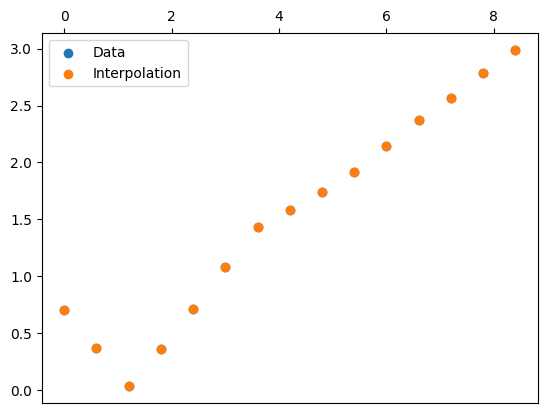

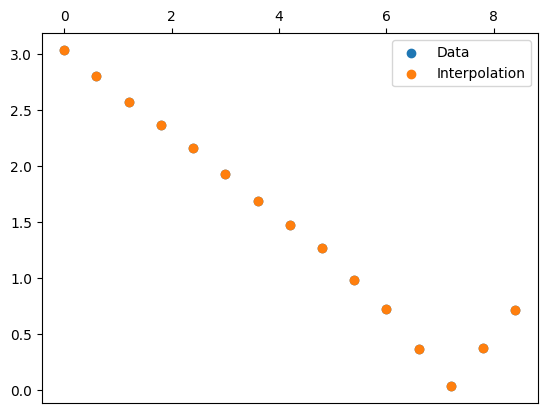

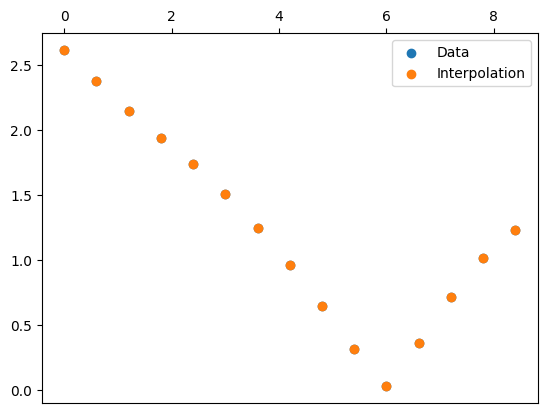

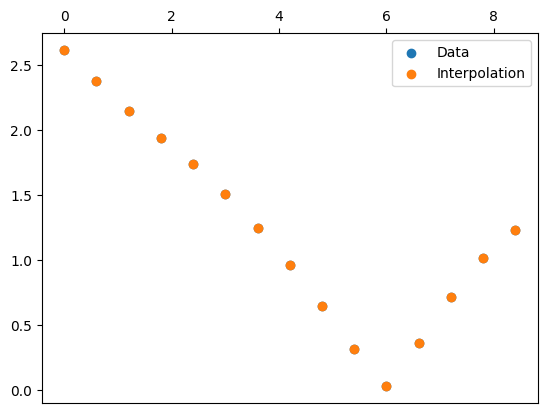

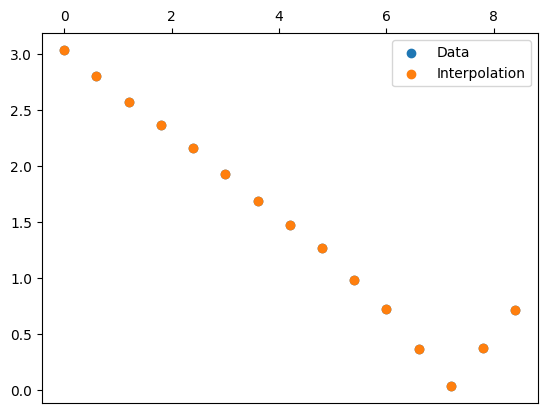

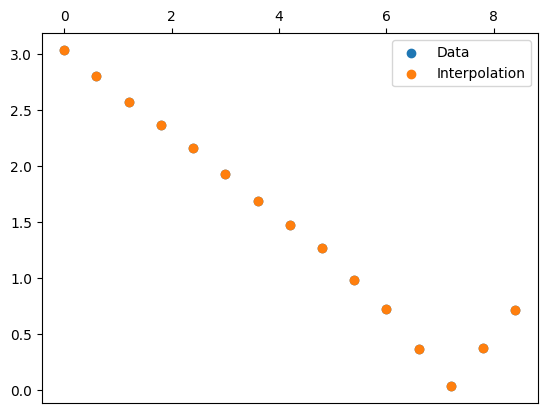

In [5]:
# Interpolation
Td_nn2 = np.zeros_like(T_data2)
taudx_nn2 = np.zeros_like(T_data2)

Ti_data2 = np.zeros((len(x[id_rec_x])*len(id_sou_x2)))
xri2 = np.tile(x[id_rec_x], len(id_sou_x2))
zri2 = np.tile(z[id_rec_z], len(id_sou_z2))
xsi2 = np.repeat(x[id_sou_x2], len(id_rec_x))
zsi2 = np.repeat(z[id_sou_z2], len(id_rec_z))

for i in range(len(id_sou_x2)):
    Ti_data2[i*len(x[id_rec_x]):(i+1)*len(x[id_rec_x])] = T_data2[id_rec_z,id_rec_x,i]

rand_idx = np.random.permutation(np.arange(len(Ti_data2)))

X_ori = np.vstack((xri2, zri2, xsi2, zsi2)).T
y_ori = Ti_data2

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(4, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn2 = np.zeros_like(T_data2)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx2)), np.tile(z[args.zid_receiver]*np.ones_like(x), len(sx2)), 
                 np.repeat(sx2, len(x)), 
                 np.repeat(z[args.zid_source]*np.ones_like(sx2), len(x))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou_x1)):
        Td_nn2[:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.png"), format='png', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model2')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #velmodel[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = velmodel.reshape(X1.shape)[np.round(SZ/deltaz).astype(int),np.round(SX2/deltax).astype(int),0]

T02 = np.sqrt((Z1-SZ)**2 + (X1-SX2)**2)/vs;
px02 = np.divide(X1-SX2, T02*vs**2, out=np.zeros_like(T02), where=T02!=0)
pz02 = np.divide(Z1-SZ, T02*vs**2, out=np.zeros_like(T02), where=T02!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x2)))
    for i in range(len(id_sou_x2)):
        f = interpolate.interp2d(x, z, T_data2[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data2, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data2[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x2),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x2),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc2 = np.zeros_like(T02)
T0_hc2 = np.zeros_like(T02)
taud_hc2 = np.zeros_like(T02)
taudx_hc2 = np.zeros_like(T02)

for i in range(len(id_sou_x2)):
    T0_hc2[:,:,i] = np.tile(T02[0,:,i], nz).reshape(nz,nx)

    # Numerical
    if data_type=='full':
        Td_hc2[:,:,i] = np.tile(T_data2[0,:,i], nz).reshape(nz,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc2[:,:,i] = Td_nn2[:,:,i].reshape(nz,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc2[:,:,i] = np.divide(Td_hc2[:,:,i], T0_hc2[:,:,i], out=np.ones_like(T0_hc2[:,:,i]),
                                   where=T0_hc2[:,:,i]!=0)
    else:
        taud_hc2[:,:,i] = Td_hc2[:,:,i] - T0_hc2[:,:,i]

    # Numerical
    if data_type=='full':
        taudx_hc2[:,:,i] = np.gradient(taud_hc2.reshape(nz,nx,len(id_sou_x2))[:,:,i], deltax, axis=1)

    # NN-based interpolation
    elif data_type=='nn':
        taudx_hc2[:,:,i] = np.gradient(taud_hc2.reshape(nz,nx,len(id_sou_x2))[:,:,i], deltax, axis=1)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")
                
# Interpolation check            
plot_int = len(id_sou_x2)//5 if len(id_sou_x2)>=5 else 1
for i in range(0, len(id_sou_x2), plot_int):
    plt.figure()
    plt.scatter(x[id_rec_x], T_data2[id_rec_z,id_rec_x,i], label='Data')
    plt.scatter(x[id_rec_x], Td_hc2[id_rec_z,id_rec_x,i], label='Interpolated')
    plt.legend(['Data', 'Interpolation'])
    plt.savefig(os.path.join(wandb_dir, "interpolation.png"), format='png', bbox_inches="tight")

# locate source boolean
import time
start_time = time.time()

TOLX = 1e-9
TOLZ = 1e-9

sids2 = np.array([]).astype(int)

for i in range(len(sx2)):
    sid = np.where(((np.abs(Z1.ravel()-z[args.zid_source])<TOLZ) & (np.abs(X1.ravel()-sx2[i])<TOLX) & (np.abs(SZ.ravel()-z[args.zid_source])<TOLZ) & (np.abs(SX2.ravel()-sx2[i])<TOLX))==True)[0]
    sids2 = np.append(sids2,sid)    

# locate source boolean
isource2 = np.ones_like(X1.reshape(-1)).reshape(-1,).astype(bool)
isource2[sids2] = False

velmodel = velmodel.reshape(-1,1)
px02 = px02.reshape(-1,1)
pz02 = pz02.reshape(-1,1)
T02 = T02.reshape(-1,1)
T_data2 = T_data2.reshape(-1,1)

taud2 = taud_hc2.reshape(-1,1)
if args.factorization_type=='multiplicative':
    taud1[~isource] = 1.    
taudx2 = taudx_hc2.reshape(-1,1)
index2 = torch.arange(T02.size)

perm_id2 = np.random.permutation(X1.size-len(sx2))

input_wsrc2 = [X1, Z1, SX2, taud2, taudx2, T02, px02, pz02, index2]
input_wosrc2 = [i.ravel()[isource2.reshape(-1)][perm_id2] for i in input_wsrc2]
if args.field_synthetic=='y':
    input_wonan2 = [i.ravel()[~np.isnan(NAN.ravel()[isource.reshape(-1)][perm_id1])] for i in input_wosrc2]

# Network
lay = 'linear'
ini = args.initialization
bias = 2
mean = 0.5
std = 1
opttype = 'adam'
lr = args.learning_rate

torch.manual_seed(seed)
if args.residual_network=='n':
    tau_model = FullyConnectedNetwork(6, 2, [args.num_neurons]*args.num_layers, last_act=args.tau_act, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
else:
    tau_model = ResidualNetwork(6, 2, num_neurons=args.num_neurons, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
tau_model.to(device)

torch.manual_seed(seed)
if args.residual_network=='n':
    v_model = FullyConnectedNetwork(2, 1, [args.num_neurons//2]*args.num_layers, act=args.activation, lay=lay, last_act='relu', last_multiplier=args.v_multiplier)
else:
    v_model = ResidualNetwork(2, 1, num_neurons=args.num_neurons//2, act='relu', last_act='relu', num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)
v_model.to(device)
v_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

perc = args.num_points

if args.irregular_grid=='y':
    npoints = int(X1.size * perc)
    ipermute = np.random.permutation(np.arange(X1.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
pde_loader2, ic = create_dataloader([i.ravel() for i in input_wsrc2], sx2, np.ones_like(sx2)*z[args.zid_source],
                                   shuffle=False, fast_loader=True, perm_id=ipermute)

if args.exp_function=='y':
    rec_op = (1-np.exp((Z1.reshape(nz,nx,len(id_sou_x2))-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = Z1.reshape(nz,nx,len(id_sou_x2))


if args.factorization_type=='multiplicative':
    tau_true = (np.divide(
        T_data2.reshape(nz,nx,len(id_sou_x2)), 
        T02.reshape(nz,nx,len(id_sou_x2)), 
        out=np.ones_like(T02.reshape(nz,nx,len(id_sou_x2))), 
        where=T02.reshape(nz,nx,len(id_sou_x2))!=0
    ))
    tau_true = tau_true - taud.reshape(nz,nx,len(id_sou_x2))
    tau_true = (np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z1.reshape(nz,nx,len(id_sou_x21))), 
        where=Z1.reshape(nz,nx,len(id_sou_x2))!=0
    ))
    T_true = (rec_op*tau_true + taud.reshape(nz,nx,len(id_sou_x2)))*T02.reshape(nz,nx,len(id_sou_x2))
else:
    tau_true = T_data2.reshape(nz,nx,len(id_sou_x2)) - T02.reshape(nz,nx,len(id_sou_x2)) - taud2.reshape(nz,nx,len(id_sou_x2))
    tau_true = (np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z1.reshape(nz,nx,len(id_sou_x2))), 
        where=Z1.reshape(nz,nx,len(id_sou_x2))!=0
    ))
    T_true = rec_op*tau_true + taud2.reshape(nz,nx,len(id_sou_x2)) + T02.reshape(nz,nx,len(id_sou_x2))

if data_type!='full':
    if args.field_synthetic=='y':
        for i in range(0, len(id_sou_x2), plot_int):
            (plot_horizontal(T_data2.reshape(X1.shape)[id_top_z,id_top_x,i], Td_nn2[id_top_z,id_top_x,i], 
                            x*args.plotting_factor,'Interpolation Comparison','T (s)',
                            'T_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z))
            (plot_horizontal(smooth(np.gradient(T_data2.reshape(X1.shape)[id_top_z,id_top_x,i]),2,'blackman'), 
                            np.gradient(Td_nn2[id_top_z,id_top_x,i]), 
                            x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
                            'Tdx_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z))
    else:
        for i in range(0, len(id_sou_x2), plot_int):
            (plot_horizontal(T_data2.reshape(X1.shape)[0,:,i], Td_nn2[0,:,i], 
                            x*args.plotting_factor,'Interpolation Comparison','T (s)',
                            'T_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z))
            (plot_horizontal(smooth(np.gradient(T_data2.reshape(X1.shape)[0,:,i]),2,'blackman'), np.gradient(Td_nn2[0,:,i]), 
                            x*args.plotting_factor,'Interpolation Comparison','dT/dx (s/km)',
                            'Tdx_comp_'+str(i)+'.png','True','NN', 
                            save_dir=wandb_dir, id_rec_x=id_rec_x, id_rec_z=id_rec_z))

### Combined

Loading time: 0.07 minutes


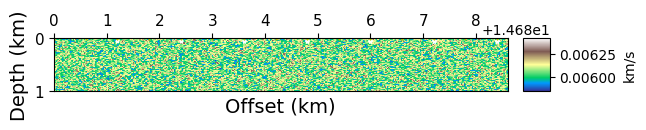

In [6]:
sids = np.array([]).astype(int)

for i in range(len(sx1)):
    sid = (np.where(((np.abs(Z1.ravel()-z[args.zid_source])<TOLZ) 
                    & (np.abs(X1.ravel()-sx1[i])<TOLX)
                    & (np.abs(X1.ravel()-sx2[i])<TOLX)
                    & (np.abs(SZ.ravel()-z[args.zid_source])<TOLZ) 
                    & (np.abs(SX1.ravel()-sx1[i])<TOLX)
                    & (np.abs(SX2.ravel()-sx2[i])<TOLX))==True)[0])
    sids = np.append(sids,sid)    

# locate source boolean
isource = np.ones_like(X1.reshape(-1)).reshape(-1,).astype(bool)
isource[sids] = False

perm_id = np.random.permutation(X1.size-2*len(sx1))

input_wsrc = [X1, Z1, SX1, SX2, taud1, taudx1, taud2, taudx2, T01, px01, pz01, T02, px02, pz02, index1]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]

pde_loader, ic1, ic2 = create_dataloaderdd([i.ravel() for i in input_wsrc], sx1, np.ones_like(sx1)*z[args.zid_source], sx2, 
                                           np.ones_like(sx1)*z[args.zid_source], 200**3, shuffle='y', 
                                                device=device, fast_loader=True, perm_id=None)

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.reduce_after, verbose=True)

v_init = evaluate_velocity(v_model, pde_loader)
tau_init = evaluate_tau(tau_model, pde_loader)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

(plot_section(torch_to_numpy(v_init, nx, nz, len(id_sou_x2))[:,:,0], "v_init.png", 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x2],sz=z[id_sou_z2],rx=x[id_rec_x],rz=z[id_rec_z]))

## Training and Inference

Epoch 0, Loss 0.0216524
Epoch 3, Loss 0.0050202
Epoch 6, Loss 0.0022476
Epoch 9, Loss 0.0020579
Epoch 12, Loss 0.0011320
Epoch 15, Loss 0.0010172
Epoch 18, Loss 0.0007853
Epoch 21, Loss 0.0012438
Epoch 24, Loss 0.0008472
Epoch 27, Loss 0.0007361
Epoch 30, Loss 0.0017762
Epoch 33, Loss 0.0012641
Epoch 36, Loss 0.0007808
Epoch 39, Loss 0.0007137
Epoch 42, Loss 0.0008267
Epoch 45, Loss 0.0006316
Epoch 48, Loss 0.0006000
Epoch 51, Loss 0.0067025
Epoch 54, Loss 0.0010081
Epoch 57, Loss 0.0006280
Epoch 60, Loss 0.0011051
Epoch 63, Loss 0.0017143
Epoch 66, Loss 0.0016995
Epoch 69, Loss 0.0014684
Epoch 72, Loss 0.0014202
Epoch 75, Loss 0.0092141
Epoch 78, Loss 0.0020191
Epoch 81, Loss 0.0011215
Epoch 84, Loss 0.0009204
Epoch 87, Loss 0.0008160
Epoch 90, Loss 0.0009689
Epoch 93, Loss 0.0007955
Epoch 96, Loss 0.0007311
Epoch 99, Loss 0.0014670
Epoch 00100: reducing learning rate of group 0 to 5.0000e-04.
Epoch 102, Loss 0.0008254
Epoch 105, Loss 0.0005558
Epoch 108, Loss 0.0004880
Epoch 111, Los

NameError: name 'pde_loader1' is not defined

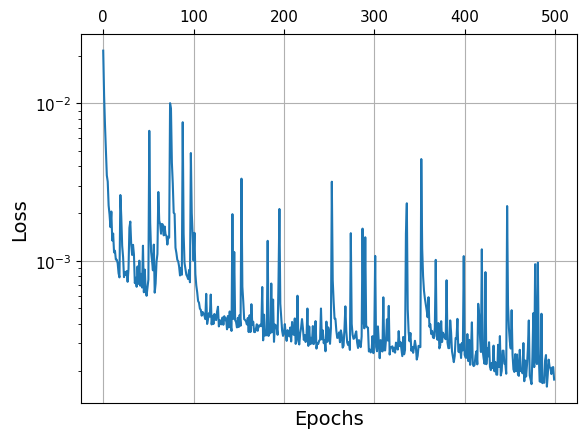

In [7]:
# # Training
# import time
# start_time = time.time()
# if args.field_synthetic=='y':
#     loss_history = \
#         training_loopdds(
#             input_wonan, sx1, np.ones_like(sx1)*z[args.zid_source], 
#             sx2, np.ones_like(sx2)*z[args.zid_source],
#             tau_model, v_model, optimizer, args.num_epochs, 
#             batch_size=Z.size//200, device=device, scheduler=scheduler,
#             fast_loader=True, args=dict_args
#     ) 
# else:
#     loss_history = \
#         training_loopdds(
#             input_wosrc, sx1, np.ones_like(sx1)*z[args.zid_source], 
#             sx2, np.ones_like(sx2)*z[args.zid_source],
#             tau_model, v_model, optimizer, args.num_epochs, 
#             batch_size=Z1.size//200, device=device, scheduler=scheduler,
#             fast_loader=True, args=dict_args
#     ) 
# elapsed = time.time() - start_time
# print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.png"), format='png', bbox_inches="tight")

# Prediction
input_wsrc = [i.ravel() for i in input_wsrc]
pde_loader, ic = create_dataloader(input_wsrc, sx, np.ones_like(sx)*sz.reshape(-1,), 
                                   shuffle=False, fast_loader=True)
v_pred = evaluate_velocity(v_model, pde_loader)

tau_pred = evaluate_tau(tau_model, pde_loader)
tau_pred = tau_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x1))

if args.factorization_type=='multiplicative':
    t_pred = (taud.reshape(nz,nx,len(id_sou_x1)) + rec_op*tau_pred)*T0.reshape(nz,nx,len(id_sou_x1))
else:
    t_pred = taud1.reshape(nz,nx,len(id_sou_x1)) + rec_op*tau_pred.reshape(nz,nx,len(id_sou_x1)) + T01.reshape(nz,nx,len(id_sou_x1))

v_pred = v_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x1))[:,:,0]
v_init = v_init.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x1))[:,:,0]
v_true = velmodel.reshape(Z1.shape)[::1,:,0]

if args.rescale_plot=='y':
    earth_radi = args.plotting_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax

    if args.depth_shift=='y':
        zmin, zmax, deltaz = earth_radi*(zmin-5), earth_radi*(zmax-5), earth_radi*deltaz
    else:
        zmin, zmax, deltaz = earth_radi*(zmin-0), earth_radi*(zmax-0), earth_radi*deltaz

    # Creating grid, extending the velocity model, and prepare list of grid points for training
    z1 = np.arange(zmin,zmax+deltaz,deltaz)
    x1 = np.arange(xmin,xmax+deltax,deltax)

    # Point-source locations
    sz1 = z1[id_sou_z1]
    sx1 = x1[id_sou_x1]

    Z1,X1,SX1 = np.meshgrid(z1,x1,sx1,indexing='ij')

    SZ = np.ones(SX1.shape)*z1[args.zid_source] # Creating an array of sources along z with same size as SX

    t_pred, T_data1, T01 = t_pred*args.plotting_factor, T_data1*args.plotting_factor, T01*args.plotting_factor

plot_section(v_pred, "v_pred.png", vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
plot_section(velmodel.reshape(Z1.shape)[:,:,0], 'v_true.png', 
             vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 

for i in range(0, len(id_sou_x), plot_int):
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_section(-tau_pred.reshape(Z1.shape)[:,:,i], "tau_pred_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_contour(t_pred.reshape(nz,nx,len(id_sou_x1)), T_true.reshape(nz,nx,len(id_sou_x1)),
                 T01.reshape(nz,nx,len(id_sou_x1)), i, nx, nz, len(id_sou_x1), sx, sz, x, z,
                 'contour_'+str(i)+'.png', save_dir=wandb_dir)
    plot_section(t_pred.reshape(nz,nx,len(id_sou_x1))[:,:,i], 't_pred_'+str(i)+'.png', 's', 
                 save_dir=wandb_dir, aspect='equal') 

v_pred[0,:] = np.copy(v_pred[1,:])

for i in range(0, len(x), len(x)//5):
    plot_trace(v_init, v_true, v_pred, i, x, z, "v_trace_"+str(i)+".png", save_dir=wandb_dir)

# Save model
torch.save({
        'tau_model1_state_dict': tau_model1.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_history
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model1.load_state_dict(checkpoint['tau_model1_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

NameError: name 'tau_model1' is not defined

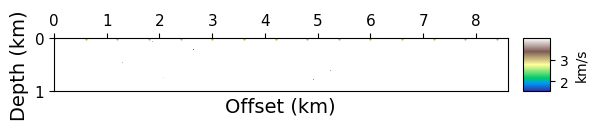

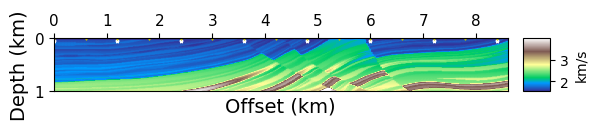

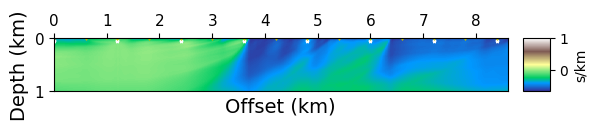

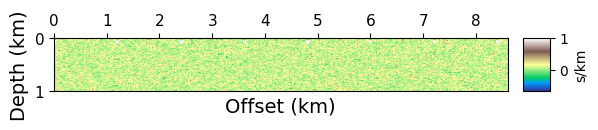

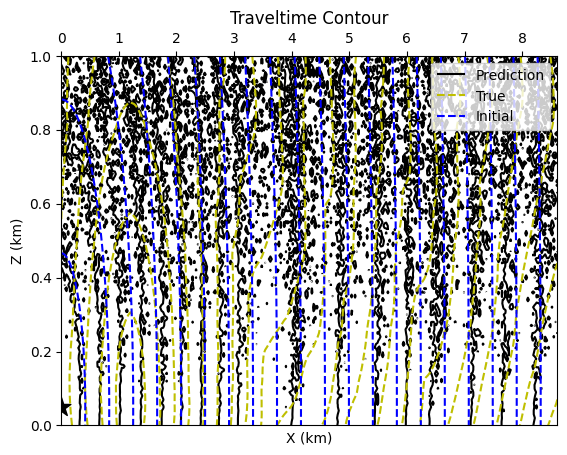

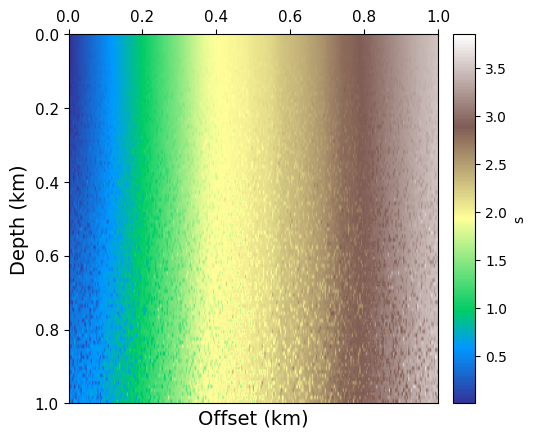

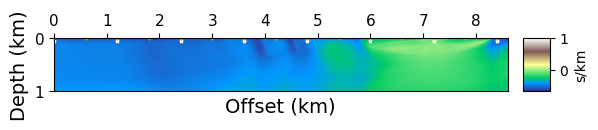

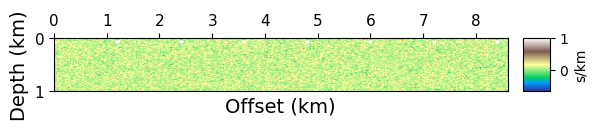

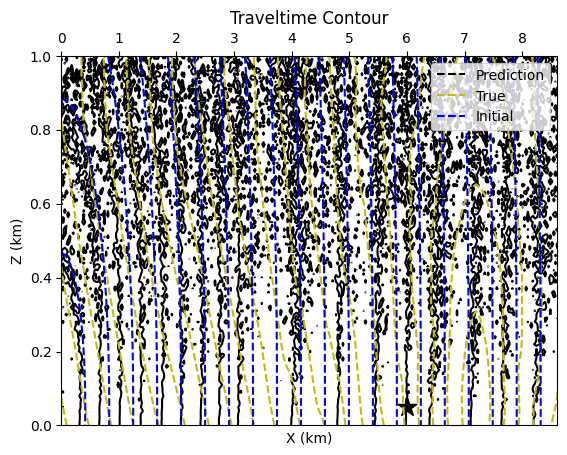

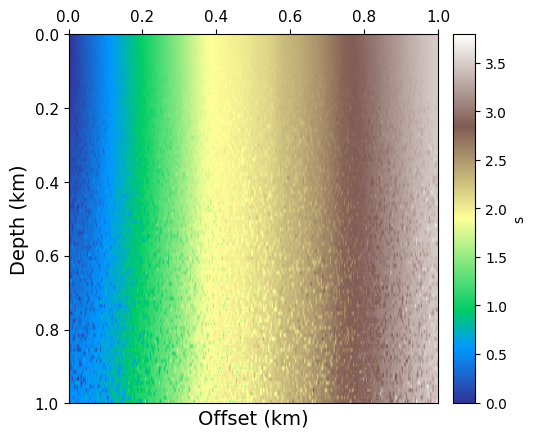

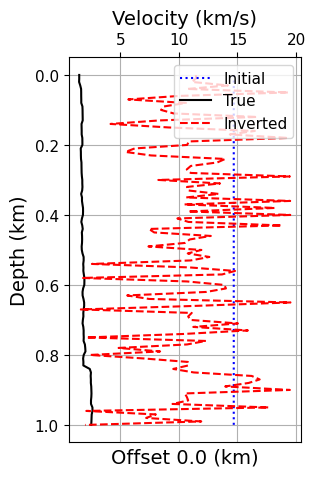

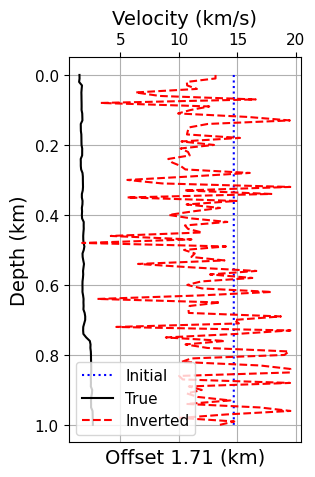

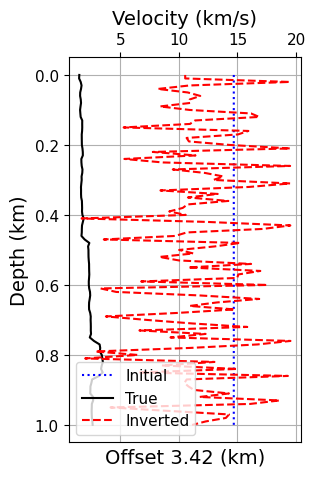

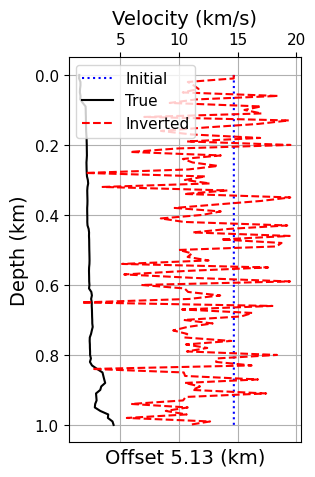

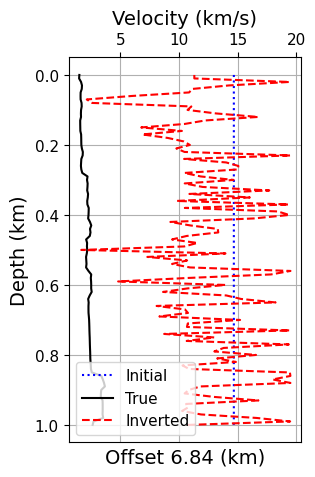

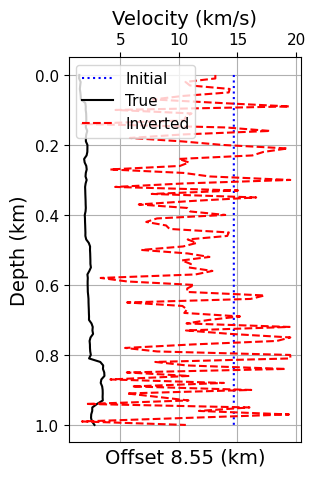

In [10]:
# Prediction
input_wsrc = [X1, Z1, SX1, SX2, taud1, taudx1, taud2, taudx2, T01, px01, pz01, T02, px02, pz02, index1]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]

pde_loader, ic1, ic2 = create_dataloaderdd([i.ravel() for i in input_wsrc], sx1, np.ones_like(sx1)*z[args.zid_source], sx2, 
                                           np.ones_like(sx1)*z[args.zid_source], 200**3, shuffle='y', 
                                                device=device, fast_loader=True, perm_id=None)
v_pred = evaluate_velocity(v_model, pde_loader)

tau_pred = evaluate_tau(tau_model, pde_loader)
tau_pred = tau_pred[:,1].detach().cpu().numpy().reshape(nz,nx,len(id_sou_x1))

if args.factorization_type=='multiplicative':
    t_pred = (taud.reshape(nz,nx,len(id_sou_x1)) + rec_op*tau_pred)*T0.reshape(nz,nx,len(id_sou_x1))
else:
    t_pred = taud1.reshape(nz,nx,len(id_sou_x1)) + rec_op*tau_pred.reshape(nz,nx,len(id_sou_x1)) + T01.reshape(nz,nx,len(id_sou_x1))

v_pred = v_pred.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x1))[:,:,0]
v_init = v_init.detach().cpu().numpy().reshape(nz,nx,len(id_sou_x1))[:,:,0]
v_true = velmodel.reshape(Z1.shape)[::1,:,0]

if args.rescale_plot=='y':
    earth_radi = args.plotting_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax

    if args.depth_shift=='y':
        zmin, zmax, deltaz = earth_radi*(zmin-5), earth_radi*(zmax-5), earth_radi*deltaz
    else:
        zmin, zmax, deltaz = earth_radi*(zmin-0), earth_radi*(zmax-0), earth_radi*deltaz

    # Creating grid, extending the velocity model, and prepare list of grid points for training
    z1 = np.arange(zmin,zmax+deltaz,deltaz)
    x1 = np.arange(xmin,xmax+deltax,deltax)

    # Point-source locations
    sz1 = z1[id_sou_z1]
    sx1 = x1[id_sou_x1]

    Z1,X1,SX1 = np.meshgrid(z1,x1,sx1,indexing='ij')

    SZ = np.ones(SX1.shape)*z1[args.zid_source] # Creating an array of sources along z with same size as SX

    t_pred, T_data1, T01 = t_pred*args.plotting_factor, T_data1*args.plotting_factor, T01*args.plotting_factor

plot_section(v_pred, "v_pred.png", vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
plot_section(velmodel.reshape(Z1.shape)[:,:,0], 'v_true.png', 
             vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='equal',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 

for i in range(0, len(id_sou_x), plot_int):
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_section(-tau_pred.reshape(Z1.shape)[:,:,i], "tau_pred_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='equal',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_contour(t_pred.reshape(nz,nx,len(id_sou_x1)), T_true.reshape(nz,nx,len(id_sou_x1)),
                 T01.reshape(nz,nx,len(id_sou_x1)), i, nx, nz, len(id_sou_x1), sx, sz, x, z,
                 'contour_'+str(i)+'.png', save_dir=wandb_dir)
    plot_section(t_pred.reshape(nz,nx,len(id_sou_x1))[:,:,i], 't_pred_'+str(i)+'.png', 's', 
                 save_dir=wandb_dir, aspect='equal') 

v_pred[0,:] = np.copy(v_pred[1,:])

for i in range(0, len(x), len(x)//5):
    plot_trace(v_init, v_true, v_pred, i, x, z, "v_trace_"+str(i)+".png", save_dir=wandb_dir)

# Save model
torch.save({
        'tau_model1_state_dict': tau_model1.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_history
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model1.load_state_dict(checkpoint['tau_model1_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])